In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ipywidgets import interact, IntSlider

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
C_O2,5.391452e+06,1.419437e+09,7.124145e+08,1.414046e+09
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06,3.226580e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08,1.824168e+09
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
NO3,1.742790e+06,1.039629e+10,5.199017e+09,1.039455e+10
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08,5.260539e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08,3.978689e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07,7.262904e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


# Make training data

In [4]:
shrink = 0.0
np.random.seed(42) # reproducible
y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(20000, nvar+1))

y0_list.shape

(20000, 75)

In [5]:
y0_list[0,:10]

array([4.71694377e+11, 1.09093885e+11, 1.52596600e+12, 8.31462679e+11,
       1.89715835e+11, 1.15236910e+11, 1.17320555e+10, 5.50189916e+12,
       7.22831335e+11, 4.96510216e-01])

In [6]:
df_y0 = pd.DataFrame(y0_list, columns=varnames+['SUN'])
df_y0.head()

,H2SO4,HCOOH,CCO_OH,RCO_OH,CCO_OOH,RCO_OOH,XN,XC,SO2,O1D,...,C_O2,BZCO_O2,RO2_R,NO,NO2,NO3,CCO_O2,RCO_O2,OH,SUN
0,4.716944e+11,1.090939e+11,1.525966e+12,8.314627e+11,1.897158e+11,1.152369e+11,1.173206e+10,5.501899e+12,7.228313e+11,0.496510,...,7.727887e+08,4.547033e+05,1.463542e+09,6.709683e+10,1.442070e+12,8.028878e+09,1.052131e+08,2.268188e+06,5.932402e+07,0.706857
1,8.979349e+11,9.216716e+10,1.812789e+11,5.029841e+11,1.408949e+11,6.375934e+11,1.253182e+11,5.133668e+12,7.642867e+10,0.218065,...,1.366336e+09,8.123958e+05,9.072652e+08,2.707952e+11,4.197773e+11,3.851659e+08,3.213416e+08,2.000715e+08,3.836694e+06,0.278646
2,1.113490e+12,4.201177e+10,3.260794e+11,6.821171e+11,1.198528e+12,1.788118e+11,1.351327e+11,5.429972e+12,2.857559e+11,0.510635,...,3.408726e+08,1.049928e+06,1.361926e+09,5.846798e+11,1.241610e+12,6.837332e+09,2.996389e+08,3.734139e+07,2.680469e+07,0.265202
3,3.147097e+11,1.111971e+11,8.333452e+11,1.232689e+12,7.674505e+11,5.871446e+11,1.010700e+11,5.302901e+12,5.922449e+11,0.136907,...,4.852021e+07,1.205069e+05,1.500762e+09,3.241772e+11,1.900243e+11,5.430226e+09,4.057361e+08,8.593959e+07,4.533778e+07,0.085347
4,8.346269e+10,6.953621e+10,1.134875e+12,8.844850e+11,8.829107e+11,7.208833e+11,1.038158e+11,5.128204e+12,9.561986e+11,0.189911,...,5.513583e+08,3.101359e+06,1.651712e+09,1.762151e+11,1.060050e+11,1.049285e+09,1.026361e+07,3.764703e+07,4.970396e+07,0.071189


In [7]:
df_y0.to_csv('train_data.csv')

In [8]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 20.3 s, sys: 4 ms, total: 20.3 s
Wall time: 20.2 s


(20000, 74)

# Normalize data

In [9]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(20000, 75)

In [11]:
Y_train = normalizer.transform(y1_list)

# Plot distribution before and after reaction

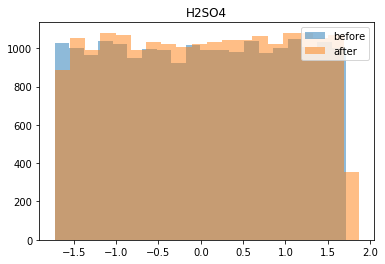

In [12]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(X_train[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(Y_train[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

# React one more step

In [13]:
%time y2_list = kpp.onestep(np.c_[y1_list, y0_list[:,-1:]].T).T  # use the same SUN as y0
y2_list.shape

CPU times: user 7.09 s, sys: 8 ms, total: 7.1 s
Wall time: 7.08 s


(20000, 74)

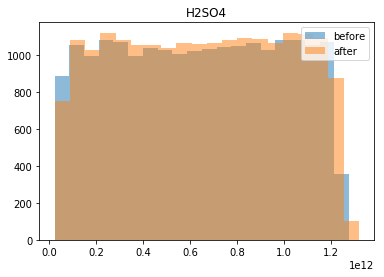

In [14]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y2_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

# Re-normalize data

In [15]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:74])

X_train = np.append(normalizer.transform(y1_list[:,0:74]), 
                    y0_list[:,-1:],  # use old SUN !
                    axis=1)
Y_train = normalizer.transform(y2_list)

# Fit ANN

In [16]:
#x_torch = Variable(torch.from_numpy(X_train))
#y_torch = Variable(torch.from_numpy(Y_train))

x_torch = Variable(torch.from_numpy(X_train)).type(torch.FloatTensor).cuda()
y_torch = Variable(torch.from_numpy(Y_train)).type(torch.FloatTensor).cuda()

In [17]:
H1, H2 = 200, 200

torch.manual_seed(7) # reproducible

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
).cuda()#double()

In [18]:
list(model.parameters())[0]

Parameter containing:
 0.0081 -0.0696  0.0368  ...   0.0632 -0.0633 -0.0271
 0.1089  0.0213  0.0081  ...  -0.0062  0.0954  0.0040
-0.0297 -0.1128 -0.1062  ...  -0.0675  0.0017  0.0252
          ...             ⋱             ...          
 0.0975  0.0947 -0.0608  ...   0.0942  0.0094 -0.0410
 0.0993  0.0867 -0.0633  ...  -0.0578 -0.0500  0.0252
-0.0034 -0.0813 -0.0826  ...   0.0353  0.1135 -0.0712
[torch.cuda.FloatTensor of size 200x75 (GPU 0)]

In [19]:
%%time
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for t in range(600):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

20 0.00476657971739769
40 0.0027975612320005894
60 0.0020969384349882603
80 0.001725238747894764
100 0.0014803429367020726
120 0.0013165355194360018
140 0.0011862436076626182
160 0.0010845480719581246
180 0.0010040198685601354
200 0.0009371524211019278
220 0.0008837530040182173
240 0.0008362314547412097
260 0.0007957796915434301
280 0.0007607510196976364
300 0.0007303837337531149
320 0.0007020289776846766
340 0.0006766514270566404
360 0.0006555960862897336
380 0.0006351317861117423
400 0.0006169091793708503
420 0.0005995504907332361
440 0.0005838118959218264
460 0.0005697429878637195
480 0.000555792183149606
500 0.0005421440582722425
520 0.0005300500197336078
540 0.0005185342160984874
560 0.0005079600377939641
580 0.0004974972107447684
600 0.00048803735990077257
CPU times: user 4min 6s, sys: 1min 4s, total: 5min 11s
Wall time: 5min 11s


In [20]:
list(model.parameters())[0]

Parameter containing:
-1.9669e-03 -6.3742e-03 -1.6819e-03  ...   2.2053e-02 -3.3278e-02  6.3223e-02
-2.5824e-05  1.1929e-04 -1.2944e-05  ...  -2.5817e-03 -3.8335e-02 -4.4682e-01
-4.1317e-03 -4.3728e-03 -9.5799e-03  ...  -3.0486e-03  1.7924e-02  1.2579e-02
                ...                   ⋱                   ...                
-1.5980e-04 -7.2200e-04  3.5545e-04  ...  -3.2094e-02  1.8427e-02 -7.1764e-02
 1.0604e-02  1.1191e-02 -5.9377e-03  ...  -3.8323e-03 -9.4209e-04 -3.1001e-02
 1.1682e-03  3.9280e-04 -2.9998e-04  ...  -1.9707e-03  1.6533e-02 -4.1770e-01
[torch.cuda.FloatTensor of size 200x75 (GPU 0)]

In [21]:
# save the model to disk
torch.save(model.state_dict(), 'trained_model.pt')

In [22]:
y_pred = model(x_torch)
#y_pred_numpy = y_pred.data.numpy()
y_pred_numpy = y_pred.cpu().data.numpy()

In [23]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99990378, 0.9997824 , 0.9999158 , 0.99992344, 0.99992151,
       0.99992028, 0.99983883, 0.99985914, 0.9999018 , 0.99987627,
       0.99990537, 0.99928298, 0.99973716, 0.99968933, 0.99958995,
       0.99953694, 0.99985119, 0.99934766, 0.99841409, 0.99989122,
       0.99989189, 0.99902173, 0.99977027, 0.99968046, 0.99930031,
       0.9997701 , 0.99941624, 0.99882388, 0.99988709, 0.99983175,
       0.99981414, 0.99900239, 0.99781589, 0.99383987, 0.99950345,
       0.99872434, 0.99970194, 0.99964474, 0.993671  , 0.99990941,
       0.99955522, 0.99989725, 0.99988751, 0.99972733, 0.99938286,
       0.99907659, 0.99469268, 0.99951043, 0.98219123, 0.9995921 ,
       0.99917379, 0.9986731 , 0.99456128, 0.99949135, 0.99951979,
       0.99951194, 0.99976341, 0.99976639, 0.99951642, 0.99987854,
       0.99967505, 0.99988378, 0.99973393, 0.99948949, 0.9995341 ,
       0.99981819, 0.99966253, 0.99974528, 0.99883848, 0.99983799,
       0.99942376, 0.99980018, 0.99974894, 0.99942077])

In [24]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9995693206136738

Text(0,0.5,'neural net prediction')

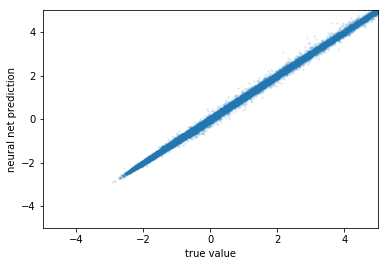

In [25]:
plt.scatter(y_pred_numpy, Y_train, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')

# Test set

In [26]:
shrink = 0.0

y0_test = np.random.uniform(df_range['min'] + shrink*df_range['span'],
                           df_range['max'] - shrink*df_range['span'], 
                           size=(5000, nvar+1))

y0_test.shape

(5000, 75)

In [27]:
%%time 
y1_test = kpp.onestep(y0_test.T).T
y2_test = kpp.onestep(np.c_[y1_test, y0_test[:,-1:]].T).T  # use the same SUN as y0
y2_test.shape

CPU times: user 6.82 s, sys: 4 ms, total: 6.83 s
Wall time: 6.81 s


In [28]:
X_test = np.append(normalizer.transform(y1_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y2_test)

In [29]:
%%time
#X_torch_test = Variable(torch.from_numpy(X_test))
#y_test_pred = model(X_torch_test).data.numpy()
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor).cuda())
y_test_pred = model(X_torch_test).data.cpu().numpy()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.01 ms


In [30]:
r2_score(y_test_pred, Y_test, multioutput='variance_weighted')

0.9993178038427472

In [31]:
r2_score(y_test_pred, Y_test, multioutput='raw_values')

array([0.99988339, 0.99975701, 0.99986215, 0.9999021 , 0.99987707,
       0.99989536, 0.99979336, 0.9998249 , 0.99979162, 0.99986273,
       0.99986074, 0.99912182, 0.99962899, 0.99961883, 0.99947443,
       0.99943331, 0.99982026, 0.99797246, 0.99814789, 0.99985698,
       0.99986383, 0.99894446, 0.99972704, 0.9995934 , 0.99898784,
       0.99972811, 0.99926142, 0.99811532, 0.9997791 , 0.99977916,
       0.99969332, 0.99878254, 0.99706644, 0.99296273, 0.99937794,
       0.99839904, 0.99951247, 0.99952819, 0.99108563, 0.99989211,
       0.99943109, 0.99984218, 0.9997867 , 0.99952074, 0.99921684,
       0.99836202, 0.98986657, 0.99913555, 0.94042192, 0.99952099,
       0.99896098, 0.99843357, 0.98210029, 0.99934308, 0.99937598,
       0.9994077 , 0.99951849, 0.9997154 , 0.99944311, 0.99984033,
       0.99957321, 0.999863  , 0.9997052 , 0.99873087, 0.99892519,
       0.99968748, 0.99934424, 0.99960795, 0.99852135, 0.99979989,
       0.99842008, 0.99963227, 0.99960375, 0.99934087])

Text(0,0.5,'neural net prediction')

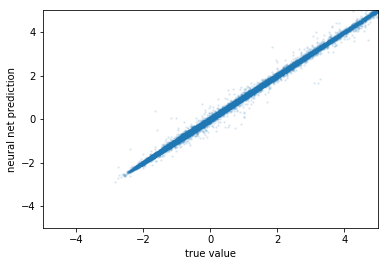

In [32]:
plt.scatter(y_test_pred, Y_test, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')

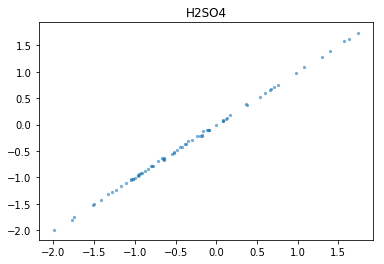

In [33]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_scatter(n):
    plt.scatter(y_test_pred[n,:], Y_test[n,:], 
                alpha=0.5, s=5.0)
    plt.title(varnames[n])

# Scale back to original concentration

In [34]:
y_test_pred_scale_back = normalizer.inverse_transform(y_test_pred)
y_test_scale_back = normalizer.inverse_transform(Y_test)

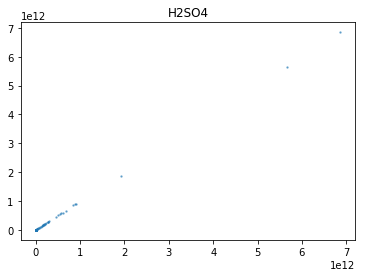

In [35]:
@interact(n=IntSlider(min=0,max=73,step=1,value=0,continuous_update=True))
def plot_scatter(n):
    plt.scatter(y_test_pred_scale_back[n,:], 
                y_test_scale_back[n,:], 
                alpha=0.5, s=2.0)
    plt.title(varnames[n])